In [9]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from random import randint
sns.set()

from IPython.display import Markdown

In [3]:
TITLE_SIZE = 18

#seeding
rng = np.random.default_rng(42)

In [25]:
# n = number of jobs 
# μ = mean_service_rate
def run_MG1_sim_and_plot(n, small_mean_service_rate, large_mean_service_rate):
    
    #contains all E[T] from the simulation
    sim_mean_response_times = [None] * 9
    
    #contains all lamdas derived from the simulation
    sim_mean_arrival_rates = [None] * 9
    
    #contains all theoretical E[T]
    th_mean_response_times = [None] * 9
    
    #contains all theoretical lamdas
    th_mean_arrival_rates = [None] * 9
    
    #runs the simulation 9 times with utilization equal to 0.1, 0.2, ... , 0.9
    for i in range(1,10):
       
        lamda = (i/10)/(0.98*(1/small_mean_service_rate) + 0.02*(1/large_mean_service_rate))
        
         #returns a dictionary with: number of jobs, μ, λ, 1/λ, 1/μ
        params = build_MG1_params(n, lamda, small_mean_service_rate, large_mean_service_rate)
        #prints the params dictionary using Markdown 
        display(Markdown(
            f"### Simulation: n={n}, " +
            f"$\lambda$={format(params['mean_arrival_rate'])}, " +
            f"$\mu_s$={format(params['small_mean_service_rate'])}, " +
            f"$\mu_l$={format(params['large_mean_service_rate'])}, " +
            f"$1/\lambda$={format(params['mean_interarrival_time'])}, " +
            f"$1/\mu_s$={format(params['small_mean_service_time'])}" +
            f"$1/\mu_l$={format(params['large_mean_service_time'])}"

        ))
        #returns simulation params such as the E[T] and the calculated lamda
        result = run_MG1_sim(params)
        
        sim_mean_response_times[i-1] = result["response_time_mean"]
        sim_mean_arrival_rates[i-1] = result["mean_arrival_rate"]
        
        #E[s]
        th_mean_service_time = 0.98*params["small_mean_service_time"] + 0.02*params["large_mean_service_time"]
        
        #E[s^2]
        th_var_service_time = 0.98*pow(params["small_mean_service_time"], 2) + 0.02*pow(params["large_mean_service_time"],2)
        
        #Ε[Τ] = E[S] + lamda*E[s^2]/(2*(1-ρ))
        th_mean_response_times[i-1] = th_mean_service_time + (lamda*th_var_service_time)/(2*(1-(i/10)))
        th_mean_arrival_rates[i-1] = lamda
       
        dump_stats(result)
    #plots E[T] as a function of lamda for theoretical and simulated M/M/1's    
    plot_MG1_response_per_lamda(sim_mean_response_times, sim_mean_arrival_rates, th_mean_response_times, th_mean_arrival_rates)

#builds the param dictionary
def build_MG1_params(num_jobs, mean_arrival_rate, small_mean_service_rate, large_mean_service_rate):
    return {
        "n": num_jobs,
        "mean_arrival_rate": mean_arrival_rate,
        "small_mean_service_rate": small_mean_service_rate,
        "large_mean_service_rate": large_mean_service_rate,
        "mean_interarrival_time": 1.0 / mean_arrival_rate,
        "small_mean_service_time": 1.0 / small_mean_service_rate,
        "large_mean_service_time": 1.0 / large_mean_service_rate,
    }

#generates the jobs and their respective arrival, wait, service times using mean_interarrival_time and μ
def run_MG1_sim(params):
    #num of jobs
    n = params["n"]
    
    #service times of jobs
    service_times = np.zeros(n)
    
    # Parameters
    mean_interarrival_time = params["mean_interarrival_time"]
    small_mean_service_time = params["small_mean_service_time"]
    large_mean_service_time = params["large_mean_service_time"]
    
    # Simulation data and results
    #generating interarrival times using exponential distribution (scale = 1/λ , where λ the rate of the exponential)
    interarrival_times = rng.exponential(scale=mean_interarrival_time, size=n)
    #arrival time of each job is the sum of all the previous interarrival times plus it's own interarrival time
    arrival_times = np.cumsum(interarrival_times)
    count_s = 0
    count_l = 0
    for i in range(1,n):
        p = randint(1,100)
        if (p>98):
            #service time for large jobs, μ = 1/201
            service_times[i] = rng.exponential(scale=large_mean_service_time)
            count_l += 1
        else:
            #service time for small jobs μ=1/1
            service_times[i] = rng.exponential(scale=small_mean_service_time)
            count_s += 1
    #now that we know when every job arrives and how much service time it needs we can find when they exit the queue "start_time"
    #and when they get serviced and exit the system "departure time"
    print("Large =  "+ str(count_l) +  "Small = "+ str(count_s))
    jobs_df = build_jobs_df(params, interarrival_times, arrival_times, service_times)
    #total time (secs) needed to service all jobs
    total_width = get_total_width(jobs_df)
    
    sim_mean_interarrival_time = jobs_df["interarrival_time"].mean()
    sim_mean_arrival_rate = 1.0 / sim_mean_interarrival_time
    sim_mean_service_time = jobs_df["service_time"].mean()
    sim_mean_service_rate = 1.0 / sim_mean_service_time
    sim_mean_wait_time = jobs_df["wait_time"].mean()
    sim_response_time_mean = jobs_df["response_time"].mean()
    sim_response_time_var = jobs_df["response_time"].var()
    
    
    
    # utilization
    util = estimate_util(jobs_df)
    
    return {
        "params": params,
        "jobs_df": jobs_df,
        "total_duration": total_width,
        "mean_arrival_rate": sim_mean_arrival_rate,
        "mean_interarrival_time": sim_mean_interarrival_time,
        "mean_service_rate": sim_mean_service_rate,
        "mean_service_time": sim_mean_service_time,
        "mean_wait_time": sim_mean_wait_time,
        "response_time_mean": sim_response_time_mean,
        "utilization": util,
    }


def build_jobs_df(params, interarrival_times, arrival_times, service_times):    
    n = params["n"]
    
    #jobs dataframe
    jobs_df = pd.DataFrame({
        "interarrival_time": interarrival_times,
        "arrive_time": arrival_times,
        "service_time": service_times,
        "start_time": np.zeros(n),
        "depart_time": np.zeros(n)
    })
    
    #first job gets serviced upon it's arrival time
    jobs_df.loc[0, "start_time"] = jobs_df.loc[0, "arrive_time"]
    #departs after it get's serviced
    jobs_df.loc[0, "depart_time"] = jobs_df.loc[0, "start_time"] + jobs_df.loc[0, "service_time"]
    
    #Every job arrives at the "Queue" upon arrival time and gets serviced when all the jobs that are already in queue get serviced
    #next job get's serviced upon arrival if queue is empty or when the previous job that is currently being serviced finishes
    for i in range(1, n):
        jobs_df.loc[i, "start_time"] = max(jobs_df.loc[i, "arrive_time"], jobs_df.loc[i-1, "depart_time"])
        jobs_df.loc[i, "depart_time"] = jobs_df.loc[i, "start_time"] + jobs_df.loc[i, "service_time"]
    
    #response time for each job is equal to queueing time plus service time or the time from when it arrives to the system
    #until it gets serviced
    jobs_df["response_time"] = jobs_df["depart_time"] - jobs_df["arrive_time"]
    jobs_df["wait_time"] = jobs_df["start_time"] - jobs_df["arrive_time"]
        
    return jobs_df


#total time system is active is equal to the time that last job finishes minus the arrival time of the 1st job in the system
def get_total_width(jobs_df):
    return jobs_df.iloc[-1]["depart_time"] - jobs_df.iloc[0]["arrive_time"]

#calculates utilization of the system: time the system services jobs / total simulation time
def estimate_util(jobs_df):
    busy = (jobs_df["depart_time"] - jobs_df["start_time"]).sum()
    return busy / get_total_width(jobs_df)

In [5]:
# STATS DUMPS

def format(value):
    return f"{value:,.4f}"

#prints usefull information
def dump_stats(result):
    params = result["params"]
    jobs_df = result["jobs_df"]
    response_time = jobs_df["response_time"]
    arrival_rate_mean = result["mean_arrival_rate"]
    service_rate_mean = result["mean_service_rate"]
    service_time_mean = result["mean_service_time"]
    response_time_mean = result["response_time_mean"]
    util = result["utilization"]
    
    print("Simulation statistics")
    print("---------------------")
    print("total_duration          = " + format(result['total_duration']))
    print("arrival_rate_mean       = " + format(arrival_rate_mean))
    print("interarrival_time_mean  = " + format(result['mean_interarrival_time']))
    # Note: E[response_time] = E[wait_time] + E[service_time]
    print("response_time")
    print("  mean                  = " + format(response_time_mean))
    print("wait_time_mean          = " + format(result['mean_wait_time']))
    print("service_rate_mean       = " + format(service_rate_mean))
    print("service_time_mean       = " + format(service_time_mean))
    print("utilization             = " + format(util))

In [6]:
# PLOTTING FUNCTIONS
#plots E[T] as a function of lamda for Theoretical and Simulation Values
def plot_MG1_response_per_lamda(sim_mean_response_times, sim_mean_arrival_rates, th_mean_response_times, th_mean_arrival_rates):
    
        
    plt.figure(figsize=(14, 2))
    plt.title("E[T] per Lamda", size=TITLE_SIZE)
    plt.xlabel("lamda")
    plt.ylabel("E[T]")
    plt.plot(th_mean_arrival_rates, th_mean_response_times, label="Theoretical", color="red")
    plt.plot(sim_mean_arrival_rates, sim_mean_response_times, label="Simulation", color="blue")
    plt.legend()
    plt.show()

### Simulation: n=100000, $\lambda$=0.0200, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=50.0000, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  2033Small = 97967
Simulation statistics
---------------------
total_duration          = 5,027,784.4129
arrival_rate_mean       = 0.0199
interarrival_time_mean  = 50.2746
response_time
  mean                  = 22.8113
wait_time_mean          = 17.7753
service_rate_mean       = 0.1986
service_time_mean       = 5.0360
utilization             = 0.1002


### Simulation: n=100000, $\lambda$=0.0400, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=25.0000, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  1944Small = 98056
Simulation statistics
---------------------
total_duration          = 2,505,800.8803
arrival_rate_mean       = 0.0399
interarrival_time_mean  = 25.0581
response_time
  mean                  = 45.2670
wait_time_mean          = 40.3346
service_rate_mean       = 0.2027
service_time_mean       = 4.9325
utilization             = 0.1968


### Simulation: n=100000, $\lambda$=0.0600, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=16.6667, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  2022Small = 97978
Simulation statistics
---------------------
total_duration          = 1,664,622.2094
arrival_rate_mean       = 0.0601
interarrival_time_mean  = 16.6432
response_time
  mean                  = 70.0459
wait_time_mean          = 65.0114
service_rate_mean       = 0.1986
service_time_mean       = 5.0345
utilization             = 0.3024


### Simulation: n=100000, $\lambda$=0.0800, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=12.5000, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  1981Small = 98019
Simulation statistics
---------------------
total_duration          = 1,248,462.9331
arrival_rate_mean       = 0.0801
interarrival_time_mean  = 12.4846
response_time
  mean                  = 117.6778
wait_time_mean          = 112.6884
service_rate_mean       = 0.2004
service_time_mean       = 4.9894
utilization             = 0.3996


### Simulation: n=100000, $\lambda$=0.1000, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=10.0000, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  1891Small = 98109
Simulation statistics
---------------------
total_duration          = 1,000,338.5130
arrival_rate_mean       = 0.1000
interarrival_time_mean  = 10.0035
response_time
  mean                  = 139.2765
wait_time_mean          = 134.5396
service_rate_mean       = 0.2111
service_time_mean       = 4.7370
utilization             = 0.4735


### Simulation: n=100000, $\lambda$=0.1200, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=8.3333, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  2036Small = 97964
Simulation statistics
---------------------
total_duration          = 834,791.0622
arrival_rate_mean       = 0.1198
interarrival_time_mean  = 8.3481
response_time
  mean                  = 308.9786
wait_time_mean          = 303.8149
service_rate_mean       = 0.1937
service_time_mean       = 5.1637
utilization             = 0.6186


### Simulation: n=100000, $\lambda$=0.1400, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=7.1429, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  1995Small = 98005
Simulation statistics
---------------------
total_duration          = 713,811.8433
arrival_rate_mean       = 0.1401
interarrival_time_mean  = 7.1379
response_time
  mean                  = 404.5407
wait_time_mean          = 399.5918
service_rate_mean       = 0.2021
service_time_mean       = 4.9489
utilization             = 0.6933


### Simulation: n=100000, $\lambda$=0.1600, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=6.2500, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  1973Small = 98027
Simulation statistics
---------------------
total_duration          = 625,265.4026
arrival_rate_mean       = 0.1599
interarrival_time_mean  = 6.2528
response_time
  mean                  = 798.1620
wait_time_mean          = 792.9774
service_rate_mean       = 0.1929
service_time_mean       = 5.1846
utilization             = 0.8292


### Simulation: n=100000, $\lambda$=0.1800, $\mu_s$=1.0000, $\mu_l$=0.0050, $1/\lambda$=5.5556, $1/\mu_s$=1.0000$1/\mu_l$=201.0000

Large =  2031Small = 97969
Simulation statistics
---------------------
total_duration          = 555,198.3404
arrival_rate_mean       = 0.1807
interarrival_time_mean  = 5.5329
response_time
  mean                  = 1,880.3777
wait_time_mean          = 1,875.2436
service_rate_mean       = 0.1948
service_time_mean       = 5.1341
utilization             = 0.9247


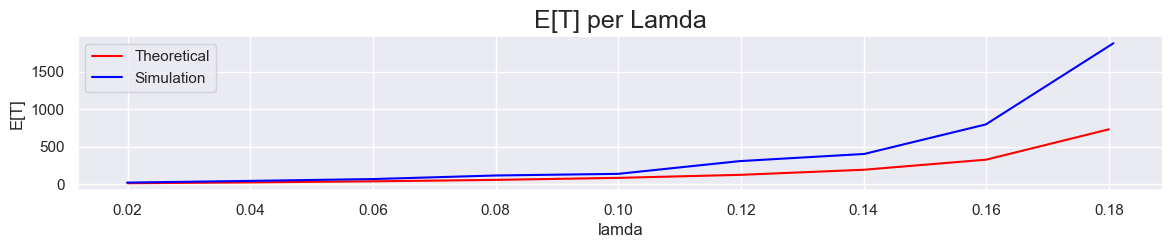

In [27]:
#M/G/1 : 98% service time = 1 sec, 2% service time = 201 secs
run_MG1_sim_and_plot(100000, 1, 1/201)